# 1 The structure of PyDFLT
In this notebook we show you the basic structure used within PyDFLT. To apply DFL, we use the following components:

1. An `OptimizationModel` which specifies the original optimization model/decision-making problem we try to tackle, including some uncertain parameters
2. A `Dataset` which includes the training data, i.e., the context/feature values that correlate with the uncertain parameters
3. The DFL `Problem` we are trying to solve, defined by the `Dataset` and `OptimizationModel`
4. A `DecisionMaker`, which includes the DFL approach that is used to learn the mapping from features to decisions. It includes a `Predictor` to (most often) map from features to uncertain parameters, and a decision model to map from uncertain parameters to decisions.
5. A `Runner` which runs the training loop to train the `DecisionMaker` in making high-quality decisions.

We will show the usage of these components in this notebook, applied to a continuous knapsack problem.



In [2]:
import os
import sys

path_to_project = os.path.dirname(os.path.abspath("")) + "/"
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("PyDFLT"))))
# Jupyter is not installed in your venv automatically, if you used uv the following will install jupyter: uv sync --group examples

## 1.1 The `OptimizationModel`
The optimization model is the formulation of the model that the decision maker wants to solve in practice. Given some realization of the uncertain parameters, solving the model will lead to a decision. Currently we support models defined as a differentiable model using CVXPY or models defined using gurobipy (including two-stage stochastic models). In `src/concrete_models` there are pre-implemented models defined. For each type of model some methods are required that define the model (for example `get_objective` and `_create_model`). As an example we will take a differentiable knapsack model.

In [1]:
from src.concrete_models import CVXPYDiffKnapsackModel

num_items = 10
optimization_model = CVXPYDiffKnapsackModel(num_decisions=num_items, capacity=20, weights_lb=3, weights_ub=8, dimension=1, seed=5)

Auto-Sklearn cannot be imported.


## 1.2 The `Dataset`
For a DFL problem there is data required with feature and uncertain parameter pairs. The `Dataset` itself is created by the problem class, so the only requirement for the data is that it is in a `dict` that has a `'features'` key and a key for each uncertain parameters as defined in the `OptimizationModel`.

In [5]:
from src.generate_data_functions.generate_data_knapsack import gen_data_knapsack

print(f"Uncertain parameter names: {optimization_model.param_to_predict_names}.")
data = gen_data_knapsack(seed=5, num_data=1000, num_items=num_items, num_features=5)
print(f"Data dictionary keys: {data.keys()}.")

Uncertain parameter names: ['item_value'].
Shape of weights: (1, 10), values: (1000, 10), features: (1000, 5).
Data dictionary keys: dict_keys(['item_value', 'features']).


## 1.3 The `Problem`
A DFL problem is defined by an optimization model and data, so we can now define the problem. It also includes the train/validation/test ratios. Optimal decisions and objectives for the in data observed parameter realization are most efficiently computed upfront, which is one of the `Problem`'s settings. There are some other settings including not randomizing the split but keeping the data in (timely) order `time_respecting_split`.

In [6]:
from src.problem import Problem

problem = Problem(
    data_dict=data,
    opt_model=optimization_model,
    train_ratio=0.7,
    val_ratio=0.15,
    compute_optimal_decisions=True,
    compute_optimal_objectives=True,
    time_respecting_split=True,
    seed=5,
)

Computing optimal decisions for the entire dataset...
Optimal decisions computed and added to dataset.
Computing optimal objectives for the entire dataset...
Optimal objectives computed and added to dataset.
Dataset split completed: Train=700, Validation=150, Test=150


## 1.4 The `DecisionMaker`
This is the object that maps from features to decisions, which is generally done using a `Predictor` that maps from features to uncertain parameters and a `decision_model` based on the defined `OptimizationModel` that maps from uncertain parameters to decisions. The `DecisionMaker` includes the method that is used to train itself and therefore always includes a `run_epoch` and an `update` method. The `DifferentiableDecisionMaker` uses differentiation. Training its `Predictor` to minimize mean squared error (Prediction-Focused Learning) for example can be done using this decision maker, but also using any differentiable surrogate losses implemented in *PyEPO* [1], or differentiating through the optimization model using *CVXPYLayers* [2] is possible. The other decision makers do not use direct differentiation, but for example use stochastic gradient estimation to differentiate. Our example problem is differentiable, so we use `'regret'` as loss function. As a predictor we use a linear predictor (Multi Layer Perceptron without hidden layers).

In [9]:
from src.decision_makers import DifferentiableDecisionMaker

decision_maker = DifferentiableDecisionMaker(
    problem=problem, learning_rate=1e-3, batch_size=64, loss_function_str="regret", predictor_str="MLP", predictor_kwargs={"num_hidden_layers": 0}, seed=5
)

Problem mode set to: train
Problem mode set to: train


## 1.5 The `Runner`
This object is used to train the `DecisionMaker`. It includes the number of epochs to run and also defines what are important metrics. When `save_best=True`, it stores the best performing model on the validation set, otherwise it just takes the model obtained after the last epoch.

In [18]:
from src.runner import Runner

runner = Runner(decision_maker=decision_maker, num_epochs=10, main_metric="objective", use_wandb=False, save_best=True, seed=5)
runner.run()

Epoch 0/10: Starting initial validation...
Problem mode set to: validation
Epoch Results:
validation/mse_mean: 63.4215
validation/rel_regret_mean: 0.3511
validation/objective_mean: 20.0181
validation/select_item_mean: 0.3833
validation/abs_regret_mean: 11.8887
validation/item_value_mean: 3.7579
validation/sym_rel_regret_mean: 0.2254
Initial best validation metric (objective): 20.018089294433594
Starting training...
Epoch: 1/10
Problem mode set to: train
Epoch Results:
validation/mse_mean: 63.4215
train/sym_rel_regret_mean: 0.2255
train/objective_mean: 18.2586
validation/rel_regret_mean: 0.3511
validation/objective_mean: 20.0181
validation/select_item_mean: 0.3833
validation/abs_regret_mean: 11.8887
train/abs_regret_mean: 10.9387
train/solver_calls_mean: 18133.6364
validation/item_value_mean: 3.7579
train/rel_regret_mean: 0.3503
validation/sym_rel_regret_mean: 0.2254
train/grad_norm_mean: 0.0000
train/loss_mean: 10.9387
Problem mode set to: validation
Epoch Results:
validation/mse_mean:

np.float32(20.01809)

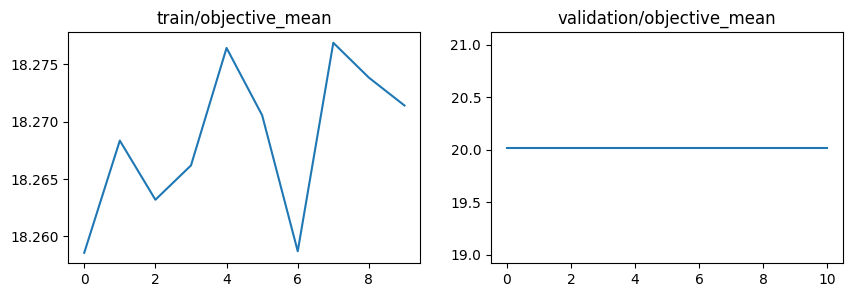

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metric = "train/objective_mean"
_ = axs[0].plot([d[metric] for d in runner.logger.epoch_metrics_list if metric in d.keys()])
_ = axs[0].set_title(metric)

metric = "validation/objective_mean"
_ = axs[1].plot([d[metric] for d in runner.logger.epoch_metrics_list if metric in d.keys()])
_ = axs[1].set_title(metric)